# 03-LL_Combinatorial libraries

In [1]:
import pandas as pd
from pydna.dseqrecord import Dseqrecord
from IPython import display

# to show assemblies
from pydna.assembly import Assembly

# Import the DesignAssembly class and the RobotAssembly class
from DesignAssembly import DesignAssembly
from RobotAssembly import RobotAssembly

# Biopython I/O + biopython objects
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import numpy as np

## 1. Intro

Up until now, the previous notebooks have enabled us to retrieve DNA sequences that enables the construction of combinatorial libraries. There are plenty of good reasons to make combinatorial libraries which I will not go into detail about here but for more information read *"Combinatorial pathway optimization for streamlined metabolic engineering"* by Jeschek et al 2017 or see the Master thesis attached to this work. The focus of this notebook is to show how combinatorial libraries can be made with a literal programming approach.  

**The general method to accomblish this is as follows:**

1. Retrieve sequences of interest, along with names
2. Make amplicons from sequences consisting of primers and their annealing temperatures
3. Generate combinatorial lists of all possible combinations
4. If a pad is wanted, add the pad at a chosen location in each list
5. Assemble contigs by making overlapping primers between each amplicon
6. Save all primers
7. Primers containing the same sequences are updated to have the same names ( happens quite frequently with homologs)
8. Unique primers are saved
9. Unique amplicons are saved


Last part of this notebook includes how robot instructions can be made from the DesignAssembly object or from predefined plates. 

**Contents of this notebook:**
    
1. Fetching data from FASTA files
2. Generating a combinatorial library for the SLS bottleneck
3. Generating Robot excecutable intructions with focus on FLOWBOT instruction

## 1.1 Data aquisition and processing
Previously I found homologs and promoters to have the neccessary parts to build a combinatorial library. These parts can be fetched from databases such as benchling or Teselagen but for ease of use it shown with fasta files here. These files are read and made into Biopython objects that that can be used for the genetic constructs. 

To build a combinatorial library from the generated promoters and homologs some of them need to be reversed. Namely, the upstream part from the pad which we can easily do with a simple Python trick (see below). 

In [2]:
SLS_CYP_sites = []
SLS_CPR_sites = []
pSLS_CPR_sites = []
pSLS_CYP_sites = []

# GEtting the objects from the fasta files
#SLS_CPR and Promoter seqs1
for seq_record in SeqIO.parse('Data/Homolog_data_files/SLS_CPR_homologs_codon_optimized.fasta', format= 'fasta'):
    SLS_CPR_sites.append(seq_record)
    
for seq_record in SeqIO.parse('Data/Promoter_FASTA_files/Promoter_sequences_2.fasta', format= 'fasta'):
    pSLS_CPR_sites.append(seq_record)
    
# REVERSE COMPLEMENT THE DNA HERE TO MAKE THE CONSTRUCTS IN THE CORRECT ORIENTATION
# SLS_CYP and Promoter seqs2
for seq_record in SeqIO.parse('Data/Homolog_data_files/SLS_CYP_homologs_codon_optimized.fasta', format= 'fasta'):    
    SLS_CYP_sites.append(seq_record[::-1])
    
for seq_record in SeqIO.parse('Data/Promoter_FASTA_files/Promoter_sequences_1.fasta', format= 'fasta'):
    pSLS_CYP_sites.append(seq_record[::-1])

Lets check that the information is read in, correctly and that the right amount of constructs are there and no mistakes have been made. 

In [3]:
print(SLS_CPR_sites[0])

ID: XP_042054710
Name: XP_042054710
Description: XP_042054710 secologanin synthase-like protein 4 [Catharanthus roseus]
Number of features: 0
Seq('ATGGATTCTACTTCTGATAATCCATCTCCATTGGAATTGATGACTGCTATGTTG...TAT')


In [4]:
print(len(SLS_CPR_sites))
print(len(pSLS_CPR_sites))
print(len(pSLS_CYP_sites))
print(len(SLS_CYP_sites))

print('Total combinations', len(SLS_CPR_sites)*len(pSLS_CPR_sites)*len(pSLS_CYP_sites)*len(SLS_CYP_sites))

8
4
4
10
Total combinations 1280


Now lets fetch the up/down sites of XI-2 and the Trp marker. 

In [5]:
UP_DW_marker = []
for seq_record in SeqIO.parse('Data/UP_DW_and_Marker/UP_DW_Marker.fasta', format= 'fasta'):
    UP_DW_marker.append(seq_record)
UP_DW_marker

[SeqRecord(seq=Seq('GAGGATTTTCGATGGAGCAGGATGAGGAGAAATAGTACCACATGTATATATCCA...CAA'), id='UP_XI-2', name='UP_XI-2', description='UP_XI-2 Upstream of XI-2 site', dbxrefs=[]),
 SeqRecord(seq=Seq('CACACGACTAGCGCTTTCAGATATTAAAAAGTTTAGATGTAGGTTTTAGCGGTA...CAC'), id='DW_XI-2', name='DW_XI-2', description='DW_XI-2 Downstream of XI-2 site', dbxrefs=[]),
 SeqRecord(seq=Seq('AGACGGTCACAGCTTGTCTGTAAGCGGATGCCGGGAGCAGACAAGCCCGTCAGG...ACG'), id='seq_3HMRtcpy', name='seq_3HMRtcpy', description='seq_3HMRtcpy <unknown description>', dbxrefs=[])]

In [6]:
UP_sites = UP_DW_marker[0]
DW_sites = UP_DW_marker[1]
marker_sites = UP_DW_marker[2]

Now the terminators ADH1 and CYC1

In [7]:
Terminators = []

for seq_record in SeqIO.parse('Data/UP_DW_and_Marker/Terminators_ADH1_CYC1.fasta', format= 'fasta'):
    Terminators.append(seq_record)

In [8]:
Terminators

[SeqRecord(seq=Seq('GCGAATTTCTTATGATTTATGATTTTTATTATTAAATAAGTTATAAAAAAAATA...ACG'), id='ADH1', name='ADH1', description='ADH1 Defined as being 0.5kb downstream of the stop codon and fetched from Intermines API', dbxrefs=[]),
 SeqRecord(seq=Seq('ACAGGCCCCTTTTCCTTTGTCGATATCATGTAATTAGTTATGTCACGCTTACAT...GAC'), id='CYC1', name='CYC1', description='CYC1 Defined as being 0.5kb downstream of the stop codon and fetched from Intermines API', dbxrefs=[])]

In [9]:
T_ADH1 = Terminators[0]
T_CYC1 = Terminators[1]

In [10]:
print(type(T_ADH1))

<class 'Bio.SeqRecord.SeqRecord'>


Now, the sequences needs to be made into Dseqrecord elements to make it into a DesignAssembly class. The names for these objects also need to be retrieved. 

In [11]:
#Getting the objects names
UP_sites_names = [UP_sites.name]
SLS_templates_names = [names.name for names in SLS_CYP_sites]
pSLS_templates_names = [names.name for names in pSLS_CYP_sites]
pSLS_CPR_templates_names = [names.name for names in pSLS_CPR_sites]
SLS_CPR_templates_names = [names.name for names in SLS_CPR_sites]
marker_templates_names = [marker_sites.name]
DW_sites_names = [DW_sites.name]
Term_ADH1_name = [T_ADH1.name]
Term_CYC1_name = [T_CYC1.name]


# Getting their sequences
UP_sites_seqrecord = [Dseqrecord(UP_sites.seq) ]
SLS_templates_seqrecord = [Dseqrecord(seq.seq) for seq in SLS_CYP_sites]
pSLS_templates_seqrecord = [Dseqrecord(seq.seq) for seq in pSLS_CYP_sites]
pCPR_templates_seqrecord = [Dseqrecord(seq.seq) for seq in pSLS_CPR_sites]
SLS_CPR_templates_seqrecord = [Dseqrecord(seq.seq) for seq in SLS_CPR_sites]
marker_templates_seqrecord = [Dseqrecord(marker_sites.seq) ]
DW_sites_seqrecord = [Dseqrecord(DW_sites.seq)]
Term_ADH1_seqrecord = [Dseqrecord(T_ADH1.seq[::-1])] # reverse the sequence here
Term_CYC1_seqrecord = [Dseqrecord(T_CYC1.seq)]

In [12]:
SLS_templates_seqrecord

[Dseqrecord(-1575),
 Dseqrecord(-1575),
 Dseqrecord(-1575),
 Dseqrecord(-1575),
 Dseqrecord(-1575),
 Dseqrecord(-1569),
 Dseqrecord(-1557),
 Dseqrecord(-1563),
 Dseqrecord(-1566),
 Dseqrecord(-1575)]

Now, for making the SLS de-bottlenecking construct. This can be achieved by following the scheme below and adding the genetic parts into lists that will be put into: 1) list of sequences 2) a list of names (final product - list of list)

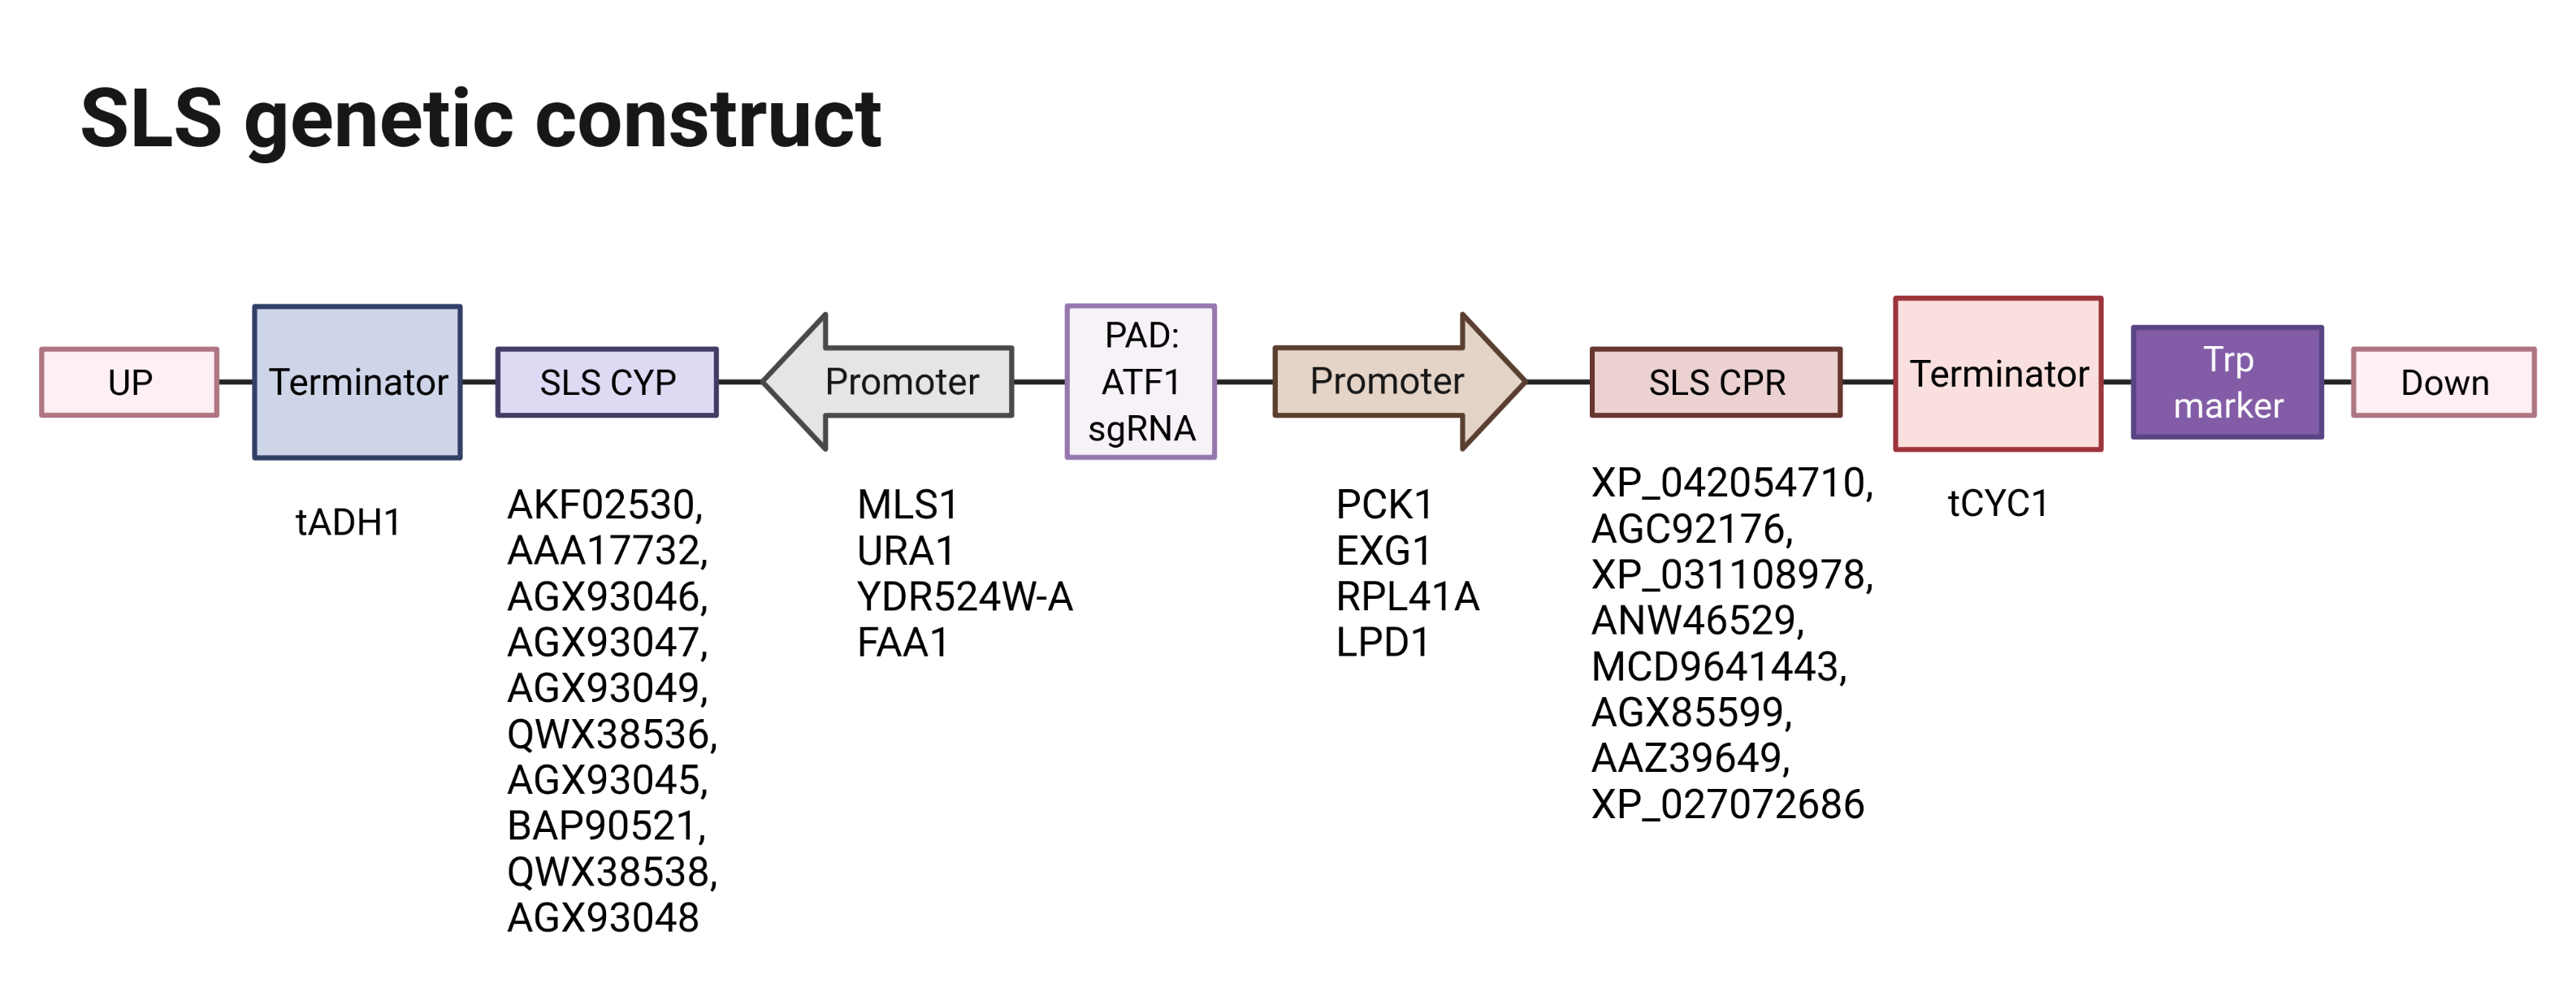

In [13]:
display.Image('Pictures/SLS_genetic_construct2601.png')

In [14]:
list_of_seqs = [UP_sites_seqrecord,Term_ADH1_seqrecord, SLS_templates_seqrecord, pSLS_templates_seqrecord, pCPR_templates_seqrecord, SLS_CPR_templates_seqrecord, Term_CYC1_seqrecord,marker_templates_seqrecord, DW_sites_seqrecord]

list_of_names = [UP_sites_names,Term_ADH1_name, SLS_templates_names, pSLS_templates_names, pSLS_CPR_templates_names, SLS_CPR_templates_names,Term_CYC1_name, marker_templates_names, DW_sites_names]

# Check that the lists are the same lenght
if len(list_of_seqs) != len(list_of_names): 
    print('!!!!!!!!!!!!!!!!!The lengths are not the same, check the sequences!!!!!!!!!!!!!!!!!!')
else: 
    print('The lengths are the same')

The lengths are the same


Now it's a good idea at this point to make sure that all the objects have been made into Dseqrecords and that they have the right size and configuration.  

In [15]:
list_of_seqs

[[Dseqrecord(-569)],
 [Dseqrecord(-500)],
 [Dseqrecord(-1575),
  Dseqrecord(-1575),
  Dseqrecord(-1575),
  Dseqrecord(-1575),
  Dseqrecord(-1575),
  Dseqrecord(-1569),
  Dseqrecord(-1557),
  Dseqrecord(-1563),
  Dseqrecord(-1566),
  Dseqrecord(-1575)],
 [Dseqrecord(-1000), Dseqrecord(-1000), Dseqrecord(-1000), Dseqrecord(-1000)],
 [Dseqrecord(-1000), Dseqrecord(-1000), Dseqrecord(-1000), Dseqrecord(-1000)],
 [Dseqrecord(-2139),
  Dseqrecord(-2124),
  Dseqrecord(-2130),
  Dseqrecord(-2133),
  Dseqrecord(-2148),
  Dseqrecord(-2142),
  Dseqrecord(-2148),
  Dseqrecord(-2139)],
 [Dseqrecord(-500)],
 [Dseqrecord(-1415)],
 [Dseqrecord(-563)]]

In [16]:
list_of_names

[['UP_XI-2'],
 ['ADH1'],
 ['AKF02530',
  'AAA17732',
  'AGX93046',
  'AGX93047',
  'AGX93049',
  'QWX38536',
  'AGX93045',
  'BAP90521',
  'QWX38538',
  'AGX93048'],
 ['MLS1', 'URA1', 'YDR524W-A', 'FAA1'],
 ['PCK1', 'EXG1', 'RPL41A', 'LPD1'],
 ['XP_042054710',
  'AGC92176',
  'XP_031108978',
  'ANW46529',
  'MCD9641443',
  'AGX85599',
  'AAZ39649',
  'XP_027072686'],
 ['CYC1'],
 ['seq_3HMRtcpy'],
 ['DW_XI-2']]

### Things to look out for when running DesignAssembly. 

1. if the melting temperature is set too low it will make a warning saying that PCR_prod is not unique. It helps to raise the melting temperature if that happens so it can make longer and unique primers 

# 2. Initiating the DesignAssembly class

Before we initiate the designAssembly object we can define and add a piece of DNA that can be used for easier genotyping and contain a crRNA so we can delete the genetic module if we need to. Below, a pad consisting of a ATF1 CRISPR Guide RNA flanked by arbitrary sequences is inititalized as a pad  

In [17]:
# ATF1_CRISPR_Guide_RNA = 'CTATGCTGTCGGATGAGTCC'
pad = Dseqrecord('GTATAGGACGCTATGCTGTCGGATGAGTCCCGTAGAATGA')
pad

Dseqrecord(-40)

We simply initiate the class by calling it with the list of sequences, their names, the pad, and the position of the pad. 
This normally takes about 20 sec. 

In [18]:
%%time
SLS_assembly = DesignAssembly(list_of_seqs, list_of_names, pad , 4 )

CPU times: user 17.9 s, sys: 128 ms, total: 18 s
Wall time: 18 s


The DesignAssembly class have class methods attached to it. These include displaying primers, the PCRs that needs to made and a graphical representation of the construts. 

The methods are as follows: 

- ShowContigs
- ShowVariantsLibDF
- PCR_list_to_dataframe
- print_PCR_list
- Primer_list_to_dataframe
- print_primer_list

Here it is shown how a dataframe with all the variants are generated:

In [19]:
combinatorial_lib_variants_df = SLS_assembly.ShowVariantsLibDF()
combinatorial_lib_variants_df

,0,1,2,3,4,5,6,7,8,Systematic_name,Variant
0,UP_XI-2,ADH1,AKF02530,MLS1,PCK1,XP_042054710,CYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 1, 1, 1, 1, 1, 1, 1)",0
1,UP_XI-2,ADH1,AKF02530,MLS1,PCK1,AGC92176,CYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 1, 1, 1, 2, 1, 1, 1)",1
2,UP_XI-2,ADH1,AKF02530,MLS1,PCK1,XP_031108978,CYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 1, 1, 1, 3, 1, 1, 1)",2
3,UP_XI-2,ADH1,AKF02530,MLS1,PCK1,ANW46529,CYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 1, 1, 1, 4, 1, 1, 1)",3
4,UP_XI-2,ADH1,AKF02530,MLS1,PCK1,MCD9641443,CYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 1, 1, 1, 5, 1, 1, 1)",4
...,...,...,...,...,...,...,...,...,...,...,...
1275,UP_XI-2,ADH1,AGX93048,FAA1,LPD1,ANW46529,CYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 10, 4, 4, 4, 1, 1, 1)",1275
1276,UP_XI-2,ADH1,AGX93048,FAA1,LPD1,MCD9641443,CYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 10, 4, 4, 5, 1, 1, 1)",1276
1277,UP_XI-2,ADH1,AGX93048,FAA1,LPD1,AGX85599,CYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 10, 4, 4, 6, 1, 1, 1)",1277
1278,UP_XI-2,ADH1,AGX93048,FAA1,LPD1,AAZ39649,CYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 10, 4, 4, 7, 1, 1, 1)",1278


We can change the coloumn names to get a better overview. 


In [20]:
combinatorial_lib_variants_df = combinatorial_lib_variants_df.rename(columns={0: 'UP_site', 1: '<-Terminator1', 2: '<- SLS-CYP', 3: '<-Promoters1', 4:'Promoters2->', 5:'SLS-CPR->', 6:'Terminator2->', 7:'Trp_marker->', 8:'Down_site'})
combinatorial_lib_variants_df

,UP_site,<-Terminator1,<- SLS-CYP,<-Promoters1,Promoters2->,SLS-CPR->,Terminator2->,Trp_marker->,Down_site,Systematic_name,Variant
0,UP_XI-2,ADH1,AKF02530,MLS1,PCK1,XP_042054710,CYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 1, 1, 1, 1, 1, 1, 1)",0
1,UP_XI-2,ADH1,AKF02530,MLS1,PCK1,AGC92176,CYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 1, 1, 1, 2, 1, 1, 1)",1
2,UP_XI-2,ADH1,AKF02530,MLS1,PCK1,XP_031108978,CYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 1, 1, 1, 3, 1, 1, 1)",2
3,UP_XI-2,ADH1,AKF02530,MLS1,PCK1,ANW46529,CYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 1, 1, 1, 4, 1, 1, 1)",3
4,UP_XI-2,ADH1,AKF02530,MLS1,PCK1,MCD9641443,CYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 1, 1, 1, 5, 1, 1, 1)",4
...,...,...,...,...,...,...,...,...,...,...,...
1275,UP_XI-2,ADH1,AGX93048,FAA1,LPD1,ANW46529,CYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 10, 4, 4, 4, 1, 1, 1)",1275
1276,UP_XI-2,ADH1,AGX93048,FAA1,LPD1,MCD9641443,CYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 10, 4, 4, 5, 1, 1, 1)",1276
1277,UP_XI-2,ADH1,AGX93048,FAA1,LPD1,AGX85599,CYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 10, 4, 4, 6, 1, 1, 1)",1277
1278,UP_XI-2,ADH1,AGX93048,FAA1,LPD1,AAZ39649,CYC1,seq_3HMRtcpy,DW_XI-2,"(1, 1, 10, 4, 4, 7, 1, 1, 1)",1278


Lets see how the first assembly overlaps. We can do that with the following code: 

In [21]:
# the first variant is chosen here
subset_of_the_assemblies = SLS_assembly.list_of_assemblies[0]
assemble = Assembly(subset_of_the_assemblies, limit = 35)
print(assemble.assemble_linear()[0].figure())

UP_XI-2|36
        \/
        /\
        36|ADH1|36
                \/
                /\
                36|AKF02530|36
                            \/
                            /\
                            36|MLS1|36
                                    \/
                                    /\
                                    36|PCK1|36
                                            \/
                                            /\
                                            36|XP_042054710|36
                                                            \/
                                                            /\
                                                            36|CYC1|36
                                                                    \/
                                                                    /\
                                                                    36|seq_3HMRtcpy|36
                                                                      

How long is the contig?

In [22]:
assemble.assemble_linear()

[Contig(-9301)]

We can retrieve the primers needed for the assembly in the following way:

In [23]:
sls_primer_df = SLS_assembly.primer_list_to_dataframe()
sls_primer_df

,ID,Anneals to,Sequence,Annealing temperature,Length,Price(DKK)
0,F001,UP_XI-2,"(G, A, G, G, A, T, T, T, T, C, G, A, T, G, G, ...",57.29,18,32.4
1,F002,ADH1,"(T, G, C, C, A, T, G, A, A, C, T, T, C, C, A, ...",56.91,37,66.6
2,F003,AKF02530,"(T, T, T, A, G, T, A, T, T, C, T, T, T, A, A, ...",55.81,45,81.0
3,F004,MLS1,"(A, A, G, G, T, A, A, A, G, T, A, A, T, A, G, ...",56.09,45,81.0
4,F005,PCK1,"(A, T, A, G, G, A, C, G, C, T, A, T, G, C, T, ...",56.80,56,100.8
...,...,...,...,...,...,...
200,R201,QWX38538,"(T, G, T, T, T, T, T, T, T, C, T, G, T, T, G, ...",54.37,37,66.6
201,R202,AGX93048,"(G, T, A, T, T, T, T, C, T, T, A, A, T, T, C, ...",55.76,38,68.4
202,R203,AGX93048,"(A, C, T, T, G, A, A, G, G, C, A, T, G, G, T, ...",55.76,38,68.4
203,R204,AGX93048,"(G, T, A, A, T, G, T, T, C, A, C, T, T, G, C, ...",55.76,38,68.4


If we want to take a closer look at the PCRs needed to complete the library do the following: 

In [24]:
sls_pcr_df = SLS_assembly.PCR_list_to_dataframe()
sls_pcr_df

,PCR#,Template,forward_primer,reverse_primer,F_tm,R_tm
0,PCR1,UP_XI-2,F001,R111,57.29,56.60
1,PCR2,ADH1,F002,R112,56.91,56.98
2,PCR3,AKF02530,F106,R113,55.81,55.60
3,PCR4,MLS1,F004,R114,56.09,56.88
4,PCR5,PCK1,F062,R124,56.80,56.83
...,...,...,...,...,...,...
132,PCR133,QWX38538,F101,R201,55.20,54.37
133,PCR134,AGX93048,F106,R202,55.81,55.76
134,PCR135,AGX93048,F106,R203,55.81,55.76
135,PCR136,AGX93048,F106,R204,55.81,55.76


With this information it is possible to: 
1. Order the primers
2. Go into the lab and make the PCRs.

Now, making that many PCRs can be a tough/tedious task to perform so lets make robot instructions that can help us increase the speed at which we make the library and limit mistakes. 

# 3. Robotassembly 

Here I show how to make robot instructions with the RobotAssembly class. 

A RobotAssembly object can be made in two ways. 

1. From an DesignAssembly object - it will make the first 96 PCR reactions by default 
2. Have already made plates with distinct configuration to make directed PCRs

How these two methods work will be shown, but lets start by examining the first method:

The first way to generate robot assembly is based on a DesignAssembly object and generates plate configuration for the first 96 PCR reactions. The user can thereby go into the lab, make the configurations and finally make the Robot perform the PCR mixing. THis method I call the Naive method and is best to use for smaller assemblies. The workflow can visualized as follows: 

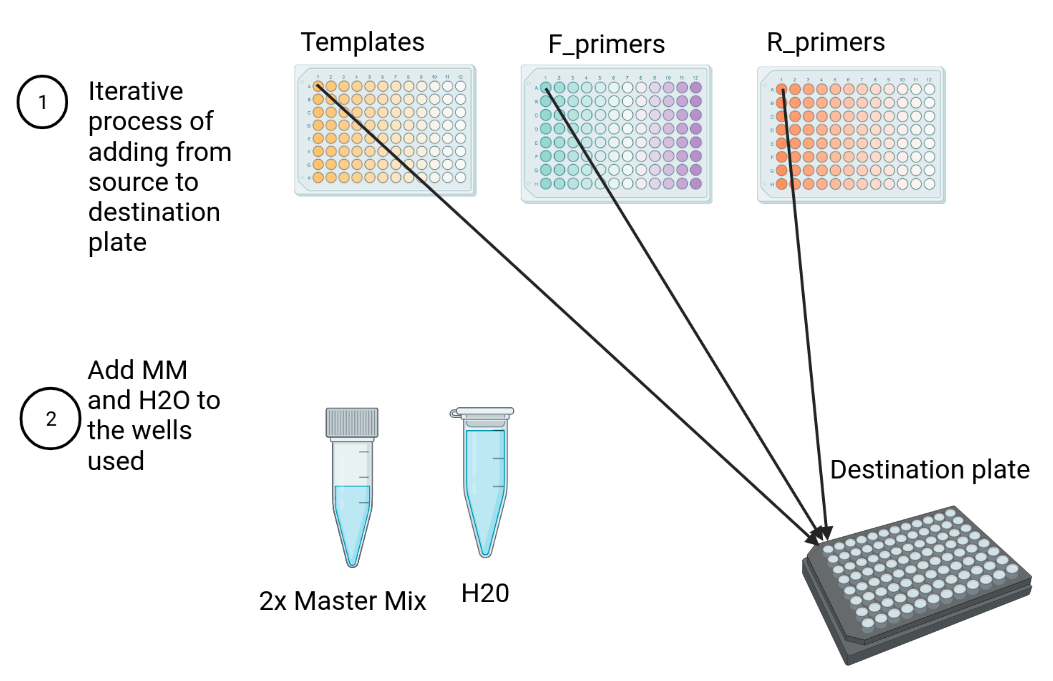

In [25]:
display.Image('Pictures/Naive_RobotAssembly.png')

We can initiate the RobotAssembly class from a Designassembly object which we made above.

In [26]:
First_Robot_assembly_object = RobotAssembly(DesignAssembly_object = SLS_assembly, Pandas_dataframe_PCR = None, F_primers =None, R_primers = None, Templates = None)

The object holds certain class methods which are listed here:
1. PlatesToExcelFile
2. FlowbotInstructionsToCSV
3. print_well_df_to_string

It also holds class instances that can be printed out but more on that later. 

Printing the configuration of the plates can be done in the following way. The configuration can also be made into an excel file which can be printed and brought into the lab. 

In [27]:
# print(First_Robot_assembly_object.print_well_df_to_string())

We can now print the picklist as a plain_string in a human readable format. It can also be printed in flowbot format whith the FlowbotInstructionsToCSV - this method makes a CSV with the instructions and is done in a similar way as the picklist to plain string. 

In [28]:
# First_Robot_assembly_object.FlowbotInstructionsToCSV()

In [29]:
# print(First_Robot_assembly_object.picklist.to_plain_string())
# print(First_Robot_assembly_object.picklist.to_flowbot_instructions())

## 2nd method 

The second method is made from a already configured plates and a dataframe holding the information about the contents of the PCRs needed to be performed. With this method a subset of all the PCRs can be chosen from the DesignAssembly dataframe and made seperately. The workflow is as follows: 

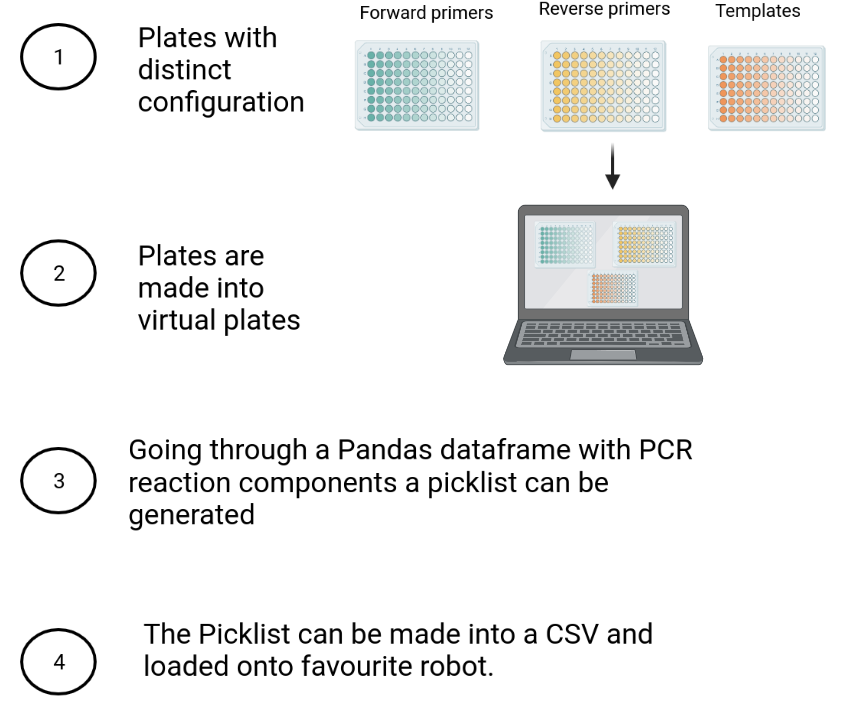

In [30]:
display.Image('Pictures/ROBOTassembly.png')

As an example we can make some virtual plates from the list of primers and templates

We can for example choose the promoter MSL1 and generate a picklist for that. We can slice it from the PCR dataframe like such: 

In [31]:
only_a_subset_templates = sls_pcr_df.loc[sls_pcr_df['Template']== 'PCK1']
only_a_subset_templates

,PCR#,Template,forward_primer,reverse_primer,F_tm,R_tm
4,PCR5,PCK1,F062,R124,56.8,56.83
9,PCR10,PCK1,F062,R120,56.8,56.83
12,PCR13,PCK1,F062,R122,56.8,56.83
15,PCR16,PCK1,F062,R126,56.8,56.83
18,PCR19,PCK1,F062,R128,56.8,56.83
20,PCR21,PCK1,F062,R130,56.8,56.83
22,PCR23,PCK1,F062,R132,56.8,56.83


This step is just to make viirtual plate of primers that we generated earlier. These lists that are generated should be made from actual plates in the lab but this serves as an example how it could look like

In [33]:
fwd_primers = []
rev_primers = []
templates = []

for index,row in sls_primer_df.iterrows(): 
    primers = row['ID']
    template = row['Anneals to']
    
    if primers.startswith('F'): 
        fwd_primers.append(primers)
    else:
        rev_primers.append(primers)
    
    if template not in templates: 
        templates.append(template)

These are all primers needed to construct the SLS library. We can take a subset of them (96) and make virtual plates and generate the instructions. 

In [34]:
f_primers = fwd_primers[:96]
r_primers = rev_primers[:96]
templates = templates[:96]

In [35]:
Robot_intstructions_test = RobotAssembly(DesignAssembly_object = None, Pandas_dataframe_PCR = only_a_subset_templates, F_primers=f_primers, R_primers = r_primers, Templates= templates)

Now a good thing to do is look at the virtual plates that we have generated with the RobotAssembly object. It can be done in a few ways but here are 2: 

1. Each plate can be accessed an made into a dataframe
2. All the plates can be printed at once. 



In [36]:
# source_plateF_primers is a class instance and can be access like this: 
Robot_intstructions_test.source_plateF_primers.to_pandas_dataframe()

,name,content,row,column
A1,A1,"{'volume': 5.0, 'quantities': {'F001': 1}}",1,1
A2,A2,"{'volume': 5.0, 'quantities': {'F002': 1}}",1,2
A3,A3,"{'volume': 5.0, 'quantities': {'F003': 1}}",1,3
A4,A4,"{'volume': 5.0, 'quantities': {'F004': 1}}",1,4
A5,A5,"{'volume': 5.0, 'quantities': {'F005': 1}}",1,5
...,...,...,...,...
H8,H8,"{'volume': 5.0, 'quantities': {'F092': 1}}",8,8
H9,H9,"{'volume': 5.0, 'quantities': {'F093': 1}}",8,9
H10,H10,"{'volume': 5.0, 'quantities': {'F094': 1}}",8,10
H11,H11,"{'volume': 5.0, 'quantities': {'F095': 1}}",8,11


With the *print_well_df_to_string* method we can print all the wells in one go. 


In [37]:
Robot_intstructions_test.print_well_df_to_string()

 ###Forward primers:  name content row column
A1 "{'volume': 5.0, 'quantities': {'F001': 1}}" 1 1
A2 "{'volume': 5.0, 'quantities': {'F002': 1}}" 1 2
A3 "{'volume': 5.0, 'quantities': {'F003': 1}}" 1 3
A4 "{'volume': 5.0, 'quantities': {'F004': 1}}" 1 4
A5 "{'volume': 5.0, 'quantities': {'F005': 1}}" 1 5
A6 "{'volume': 5.0, 'quantities': {'F006': 1}}" 1 6
A7 "{'volume': 5.0, 'quantities': {'F007': 1}}" 1 7
A8 "{'volume': 5.0, 'quantities': {'F008': 1}}" 1 8
A9 "{'volume': 5.0, 'quantities': {'F009': 1}}" 1 9
A10 "{'volume': 5.0, 'quantities': {'F010': 1}}" 1 10
A11 "{'volume': 5.0, 'quantities': {'F011': 1}}" 1 11
A12 "{'volume': 5.0, 'quantities': {'F012': 1}}" 1 12
B1 "{'volume': 5.0, 'quantities': {'F013': 1}}" 2 1
B2 "{'volume': 5.0, 'quantities': {'F014': 1}}" 2 2
B3 "{'volume': 5.0, 'quantities': {'F015': 1}}" 2 3
B4 "{'volume': 5.0, 'quantities': {'F016': 1}}" 2 4
B5 "{'volume': 5.0, 'quantities': {'F017': 1}}" 2 5
B6 "{'volume': 5.0, 'quantities': {'F018': 1}}" 2 6
B7 "{'volume

Lets check out the picklist generated for the PCR reactions we made in FLOWBOT INSTRUCTIONS

The first number from the source and target columns indicate which plate the action is performed on, followed by which well. 

So this: 

source, target, volume
1:A4, 5:A1, 1 

means that plate 1, well A4 is transferd to target plate 5, A1 and the volume is 1. 

In [46]:
print(Robot_intstructions_test.picklist.to_plain_string())

Transfer 1.00E+00L from 1 F2 into 5 A1
Transfer 1.00E+00L from 2 B2 into 5 A1
Transfer 1.00E+00L from 3 A5 into 5 A1
Transfer 1.00E+01L from 4 A1 into 5 A1
Transfer 7.00E+00L from 4 A2 into 5 A1
Transfer 1.00E+00L from 1 F2 into 5 A2
Transfer 1.00E+00L from 2 A10 into 5 A2
Transfer 1.00E+00L from 3 A5 into 5 A2
Transfer 1.00E+01L from 4 A1 into 5 A2
Transfer 7.00E+00L from 4 A2 into 5 A2
Transfer 1.00E+00L from 1 F2 into 5 A3
Transfer 1.00E+00L from 2 A12 into 5 A3
Transfer 1.00E+00L from 3 A5 into 5 A3
Transfer 1.00E+01L from 4 A1 into 5 A3
Transfer 7.00E+00L from 4 A2 into 5 A3
Transfer 1.00E+00L from 1 F2 into 5 A4
Transfer 1.00E+00L from 2 B4 into 5 A4
Transfer 1.00E+00L from 3 A5 into 5 A4
Transfer 1.00E+01L from 4 A1 into 5 A4
Transfer 7.00E+00L from 4 A2 into 5 A4
Transfer 1.00E+00L from 1 F2 into 5 A5
Transfer 1.00E+00L from 2 B6 into 5 A5
Transfer 1.00E+00L from 3 A5 into 5 A5
Transfer 1.00E+01L from 4 A1 into 5 A5
Transfer 7.00E+00L from 4 A2 into 5 A5
Transfer 1.00E+00L from

The picklist exported as a CSV file. Then loaded onto ur favourite robot and the assembly initated.

In [ ]:
Robot_intstructions_test.FlowbotInstructionsToCSV()

## Conclusion

1. A combinatorial library was made
2. Instructions for Flowbot One was automatically generated for the assembly of the combinatorial library. 